# B02. Simulations
- Simulate matchups

In [1]:
%run "C:\Users\james\Documents\MLB\Code\U1. Imports.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U2. Utilities.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U3. Classes.ipynb"


baseball_path = r'C:\Users\james\Documents\MLB\Database'

db_path = r'C:\Users\james\Documents\MLB\Database\MLBDB.db'
engine = create_engine(f'sqlite:///{db_path}')

### Scale Inputs

In [2]:
def scale_inputs(away_batter_df, away_pitcher_df, home_batter_df, home_pitcher_df, batter_stats_scaler, batter_stats_fg_scaler, pitcher_stats_scaler, pitcher_stats_fg_scaler):
    ### Standardize stats
    # Away batters
    away_batter_df[batter_stats_l] = batter_stats_scaler.fit_transform(away_batter_df[batter_stats_l])
    away_batter_df[batter_stats_r] = batter_stats_scaler.fit_transform(away_batter_df[batter_stats_r])
    away_batter_df[batter_stats_fg] = batter_stats_fg_scaler.fit_transform(away_batter_df[batter_stats_fg])
    # Away pitchers
    away_pitcher_df[pitcher_stats_l] = pitcher_stats_scaler.fit_transform(away_pitcher_df[pitcher_stats_l])
    away_pitcher_df[pitcher_stats_r] = pitcher_stats_scaler.fit_transform(away_pitcher_df[pitcher_stats_r])
    away_pitcher_df[pitcher_stats_fg] = pitcher_stats_fg_scaler.fit_transform(away_pitcher_df[pitcher_stats_fg])

    # Home batters
    home_batter_df[batter_stats_l] = batter_stats_scaler.fit_transform(home_batter_df[batter_stats_l])
    home_batter_df[batter_stats_r] = batter_stats_scaler.fit_transform(home_batter_df[batter_stats_r])
    home_batter_df[batter_stats_fg] = batter_stats_fg_scaler.fit_transform(home_batter_df[batter_stats_fg])
    # Home pitchers
    home_pitcher_df[pitcher_stats_l] = pitcher_stats_scaler.fit_transform(home_pitcher_df[pitcher_stats_l])
    home_pitcher_df[pitcher_stats_r] = pitcher_stats_scaler.fit_transform(home_pitcher_df[pitcher_stats_r])
    home_pitcher_df[pitcher_stats_fg] = pitcher_stats_fg_scaler.fit_transform(home_pitcher_df[pitcher_stats_fg])
    
    return away_batter_df, away_pitcher_df, home_batter_df, home_pitcher_df

### Impute Inputs

In [3]:
def impute_batters(batter_df, batter_imputations_model):
    ### Vs. RHP
    # Create is lefty dummy (this will include switch hitters against righties)
    batter_df['b_L'] = (batter_df['batSide'] != 'Right').astype('int')
    # Vs. RHP
    batter_df['p_L'] = 0    
    # If missing data, impute
    batter_df['imp_b_r'].fillna(1, inplace=True)
    # Impute
    try:
        prediction = batter_imputations_model.predict(batter_df.loc[batter_df['imp_b_r'] == 1, batter_stats_fg_imp])
    except:
        prediction = None
        print("No batter imputations vs RHP")
    # Impute missing values in pitcher_stats with the predicted values
    batter_df.loc[batter_df['imp_b_r'] == 1, batter_stats_r] = prediction
    
    
    ### Vs. LHP
    # Create is lefty dummy (this will not include switch hitters against righties)
    batter_df['b_L'] = (batter_df['batSide'] == 'Left').astype('int')
    # Vs. RHP
    batter_df['p_L'] = 1  
    # If missing data, impute
    batter_df['imp_b_l'].fillna(1, inplace=True)
    # Impute
    try:
        prediction = batter_imputations_model.predict(batter_df.loc[batter_df['imp_b_l'] == 1, batter_stats_fg_imp])
    except:
        prediction = None
        print("No batter imputations vs LHP")
    # Impute missing values in pitcher_stats with the predicted values
    batter_df.loc[batter_df['imp_b_l'] == 1, batter_stats_l] = prediction
    
    return batter_df

In [4]:
def impute_pitchers(pitcher_df, pitcher_imputations_model):
    ### Vs. RHB
    # Create is lefty dummy 
    pitcher_df['p_L'] = (pitcher_df['pitchHand'] == 'Left').astype('int')
    # Vs. RHB
    pitcher_df['b_L'] = 0    
    # If missing data, impute
    pitcher_df['imp_p_r'].fillna(1, inplace=True)
    # Impute
    try:
        prediction = pitcher_imputations_model.predict(pitcher_df.loc[pitcher_df['imp_p_r'] == 1, pitcher_stats_fg_imp])
    except:
        prediction = None
        print("No pitcher imputations vs LHB")
    # Impute missing values in pitcher_stats with the predicted values
    pitcher_df.loc[pitcher_df['imp_p_r'] == 1, pitcher_stats_r] = prediction

    
    ### Vs. LHB
    # Create is lefty dummy 
    pitcher_df['p_L'] = (pitcher_df['pitchHand'] == 'Left').astype('int')
    # Vs. RHB
    pitcher_df['b_L'] = 1  
    # If missing data, impute
    pitcher_df['imp_p_l'].fillna(1, inplace=True)  
    # Impute
    try:
        prediction = pitcher_imputations_model.predict(pitcher_df.loc[pitcher_df['imp_p_l'] == 1, pitcher_stats_fg_imp])
    except:
        prediction = None
        print("No pitcher imputations vs LHB")        
    # Impute missing values in pitcher_stats with the predicted values
    pitcher_df.loc[pitcher_df['imp_p_l'] == 1, pitcher_stats_l] = prediction
    
    return pitcher_df

### Create Matchup Objects

In [5]:
# Create team-position objects
def create_matchup(matchup, matchup_path, batter_stats_scaler, batter_stats_fg_scaler, batter_imputations_model, pitcher_stats_scaler, pitcher_stats_fg_scaler, pitcher_imputations_model):
    ### Read in data
    # Batters
    away_batter_df = pd.read_excel(os.path.join(matchup_path, matchup), sheet_name='AwayBatters', engine='openpyxl')
    home_batter_df = pd.read_excel(os.path.join(matchup_path, matchup), sheet_name='HomeBatters', engine='openpyxl')
    
    # Pitchers
    away_pitcher_df = pd.read_excel(os.path.join(matchup_path, matchup), sheet_name='AwayPitchers', engine='openpyxl')
    home_pitcher_df = pd.read_excel(os.path.join(matchup_path, matchup), sheet_name='HomePitchers', engine='openpyxl')
    
    
    # Column names
    batter_columns = away_batter_df.columns.tolist()
    pitcher_columns = away_pitcher_df.columns.tolist()
    
    
    ### Scale inputs
    away_batter_df, away_pitcher_df, home_batter_df, home_pitcher_df = scale_inputs(away_batter_df, away_pitcher_df, home_batter_df, home_pitcher_df, batter_stats_scaler, batter_stats_fg_scaler, pitcher_stats_scaler, pitcher_stats_fg_scaler)
    ### Impute inputs
    away_batter_df = impute_batters(away_batter_df, batter_imputations_model)
    home_batter_df = impute_batters(home_batter_df, batter_imputations_model)
    away_pitcher_df = impute_pitchers(away_pitcher_df, pitcher_imputations_model)
    home_pitcher_df = impute_pitchers(home_pitcher_df, pitcher_imputations_model)

    
    
   
    
    ### Create player objects
    # Lists of player objects, by Away/Home status and position group
    AwayBatters = []
    HomeBatters = []
    AwayPitchers = []
    HomePitchers = []
    
    # Away Batters
    for _, row in away_batter_df.iterrows():
        batter_data = {attr: row[attr] for attr in batter_columns}
        AwayBatters.append(Batter(**batter_data))
    
    # Home Batters
    for _, row in home_batter_df.iterrows():
        batter_data = {attr: row[attr] for attr in batter_columns}
        HomeBatters.append(Batter(**batter_data))

    # Away Pitchers
    for _, row in away_pitcher_df.iterrows():
        pitcher_data = {attr: row[attr] for attr in pitcher_columns}
        AwayPitchers.append(Pitcher(**pitcher_data))
    
    # Home Pitchers
    for _, row in home_pitcher_df.iterrows():
        pitcher_data = {attr: row[attr] for attr in pitcher_columns}
        HomePitchers.append(Pitcher(**pitcher_data))
    

    return AwayBatters, HomeBatters, AwayPitchers, HomePitchers 

### Calculate Pull Odds

In [6]:
# Calculate odds of being pulled
def pull_odds(game, model_pulls):
    # Determine batting and fielding team scores for use as inputs
    if game.top_bot == "Top":        
        batter_score = game.away_score
        pitcher_score = game.home_score
    else:
        batter_score = game.home_score
        pitcher_score = game.away_score
    
    # Pull model inputs (pull_inputs3)
    X_list = [
        game.pitching.B1, game.pitching.B2, game.pitching.B3, game.pitching.HR, game.pitching.BB, game.pitching.HBP, 
        game.pitching.SO, game.pitching.ER, game.pitching.faced, pitcher_score, batter_score, game.pitching.IP_start
            ]
    
    # Reshape to match what models expect
    model_inputs = pd.Series(X_list).values.reshape(1,-1)

    # Predict and make into a list
    pull_list = model_pulls.predict_proba(model_inputs).tolist()
    
    # Choose the probability that pull = 1
    odds = pull_list[0][1] 
    
    del X_list, model_inputs, pull_list
    
    return odds

### Determine PA Matchup

In [7]:
def choose_pa_matchup(game, model_pulls, opener_list):    
    ### Top of the inning
    if game.top_bot == "Top":
        # Shuffle list of pitchers so that when a pitcher is decided based on being the first in the list with a given leverage, that pitcher will vary
        # random.shuffle(game.home_pitchers)
       
        ### Determine leverage
        # If the starter is still in the game
        if game.home_starter_pulled == False:
            # Pitcher is the starter
            # game.home_pitcher_up = next(pitcher for pitcher in game.home_pitchers if pitcher.Leverage == 1)
            game.home_pitcher_up = random.choice([pitcher for pitcher in game.home_pitchers if pitcher.Leverage == 1]) if game.home_pitchers else None
            game.pitching = game.home_pitcher_up
            # Roll to see if they'll be pulled
            pull_prob = pull_odds(game, model_pulls)
            pull_roll = random.random()
            if pull_roll < pull_prob:
                game.home_starter_pulled = True 
    
            # If they're an opener and it's the third inning,
            if game.inning >= 3 and game.home_starter.Name in opener_list:
                # Pull them
                game.home_starter_pulled = True
            
        # If the home starter has been pulled
        if game.home_starter_pulled == True:
            # Set leverage to 2 (low) by default
            game.home_leverage = 2
            # Set leverage to 3 (medium) if it's late
            if (game.inning > game.innings - 3):
                game.home_leverage = 3
            # Set leverage to 4 (high) if it's a save situation
            if (4 > (game.home_score - game.away_score) >= 0) and game.inning == game.innings and game.home_starter_pulled == True:
                game.home_leverage = 4
        
        # Pick pitcher
        try:
            # Try to use method above
            # game.home_pitcher_up = next(pitcher for pitcher in game.home_pitchers if pitcher.Leverage == game.home_leverage)
            game.home_pitcher_up = random.choice([pitcher for pitcher in game.home_pitchers if pitcher.Leverage == game.home_leverage]) if game.home_pitchers else None
        except:
            # Might not have a pitcher at every leverage. In that case, choose low leverage
            # game.home_pitcher_up = next(pitcher for pitcher in game.home_pitchers if pitcher.Leverage == 2)    
            game.home_pitcher_up = random.choice([pitcher for pitcher in game.home_pitchers if pitcher.Leverage == 2]) if game.home_pitchers else None

    
        # Determine matchup
        game.pitching = game.home_pitcher_up
        game.ab = next(batter for batter in game.away_batters if batter.batting_order == game.away_order)
      
    
    
    ### Bottom of the inning
    elif game.top_bot == "Bot":
        # Shuffle list of pitchers so that when a pitcher is decided based on being the first in the list with a given leverage, that pitcher will vary
        # random.shuffle(game.away_pitchers)
       
        ### Determine leverage
        # If the starter is still in the game
        if game.away_starter_pulled == False:
            # Pitcher is the starter
            # game.away_pitcher_up = next(pitcher for pitcher in game.away_pitchers if pitcher.Leverage == 1)
            game.away_pitcher_up = random.choice([pitcher for pitcher in game.away_pitchers if pitcher.Leverage == 1]) if game.away_pitchers else None
            game.pitching = game.away_pitcher_up
            # Roll to see if they'll be pulled
            pull_prob = pull_odds(game, model_pulls)
            if game.top_bot == "Top":        
                batter_score = game.away_score
                pitcher_score = game.home_score
            else:
                batter_score = game.home_score
                pitcher_score = game.away_score
            X_list = [
        game.pitching.B1, game.pitching.B2, game.pitching.B3, game.pitching.HR, game.pitching.BB, game.pitching.HBP, 
        game.pitching.SO, game.pitching.ER, game.pitching.faced, pitcher_score, batter_score, game.pitching.IP_start
            ]
            print(game.pitching.Name)
            print(X_list)
            print(pull_prob)
            pull_roll = random.random()
            if pull_roll < pull_prob:
                game.away_starter_pulled = True 
    
            # If they're an opener and it's the third inning,
            if game.inning >= 3 and game.away_starter.Name in opener_list:
                # Pull them
                game.away_starter_pulled = True
            
        # If the home starter has been pulled
        if game.away_starter_pulled == True:
            # Set leverage to 2 (low) by default
            game.away_leverage = 2
            # Set leverage to 3 (medium) if it's late
            if (game.inning > game.innings - 3):
                game.away_leverage = 3
            # Set leverage to 4 (high) if it's a save situation
            if (4 > (game.away_score - game.home_score) >= 0) and game.inning == game.innings and game.away_starter_pulled == True:
                game.away_leverage = 4
        
        # Pick pitcher
        try:
            # Try to use method above
            # game.away_pitcher_up = next(pitcher for pitcher in game.away_pitchers if pitcher.Leverage == game.away_leverage)
            game.away_pitcher_up = random.choice([pitcher for pitcher in game.away_pitchers if pitcher.Leverage == game.away_leverage]) if game.away_pitchers else None
        except:
            # Might not have a pitcher at every leverage. In that case, choose low leverage
            # game.away_pitcher_up = next(pitcher for pitcher in game.away_pitchers if pitcher.Leverage == 2)    
            game.away_pitcher_up = random.choice([pitcher for pitcher in game.away_pitchers if pitcher.Leverage == 2]) if game.away_pitchers else None
    
        # Determine matchup
        game.pitching = game.away_pitcher_up
        game.ab = next(batter for batter in game.home_batters if batter.batting_order == game.home_order)
    
    return game

### Probabilities

In [8]:
# Create PA event probability
def probabilities(game, model_binary, model_outs, model_safe):
    
    # Batter attributes
    # Set batter attributes specific to pitcher hand
    for stat in batter_stats + ['imp_b']:
        if game.pitching.pitchHand == "Left":
            attr_name = f'{stat}_l'
        else:
            attr_name = f'{stat}_r'

        # Get the new attribute value
        new_value = getattr(game.ab, attr_name)

        # Set the attribute to the new value
        setattr(game.ab, stat, new_value)
        
    # Pitcher attributes
    # Set pitcher attributes specific to batter hand
    for stat in pitcher_stats + ['imp_p']:
        if game.ab.batSide == "Left" or (game.ab.batSide == "Switch" and game.pitching.pitchHand == "Right"):
            attr_name = f'{stat}_l'
        else:
            attr_name = f'{stat}_r'

        # Get the new attribute value
        new_value = getattr(game.pitching, attr_name)

        # Set the attribute to the new value
        setattr(game.pitching, stat, new_value)
        
    
    
    # Make compatible with model
    if game.ab.batSide == "Left" or (game.ab.batSide == "Switch" and game.pitching.pitchHand == "Right"):
        game.ab.b_L = 1
    else:
        game.ab.b_L = 0
    
    if game.pitching.pitchHand == "Left":
        game.pitching.p_L = 1
    else:
        game.pitching.p_L = 0
        
    # On base dummies
    if game.on_1b is not None:
        game.onFirst = 1
    else:
        game.onFirst = 0
    if game.on_2b is not None:
        game.onSecond = 1
    else:
        game.onSecond = 0
    if game.on_3b is not None:
        game.onThird = 1
    else: 
        game.onThird = 0
        
    # Top of the inning dummy
    if game.top_bot == "Top":
        game.top = 1
    else:
        game.top = 0

    # SCore differentials
    if game.top == 1:
        game.score_diff = game.away_score - game.home_score
    else:
        game.score_diff = game.home_score - game.away_score
    
    # Year dummies
    game.year_2015 = 0
    game.year_2016 = 0
    game.year_2017 = 0
    game.year_2018 = 0
    game.year_2019 = 0
    game.year_2020 = 0
    game.year_2021 = 0
    game.year_2022 = 0
    game.year_2023 = 1

    
    
    ### Inputs
    # Batters
    batter_inputs =  [getattr(game.ab, stat) for stat in batter_stats]
    
    # Pitchers
    pitcher_inputs = [getattr(game.pitching, stat) for stat in pitcher_stats]
    
    # Venues
    for num in venues:  # Iterate through your venue values
        venue_attribute_name = f'venue_{num}'  # Create the attribute name
        if getattr(game.ab.venue_id, 'venue_id', None) == num:
            setattr(game, venue_attribute_name, 1)
        else:
            setattr(game, venue_attribute_name, 0)
    venue_inputs = [getattr(game, venue) for venue in venues]

    # Years 
    year_inputs = [getattr(game, year) for year in years]
    
    
    
    # Other 
    other_inputs = [game.pitching.p_L, game.ab.b_L, 
                    game.ab.x_vect, game.ab.y_vect, game.ab.temperature, 
                    game.onFirst, game.onSecond, game.onThird, game.inning, game.top, game.score_diff]
    
    imp_inputs = [game.ab.imp_b, game.pitching.imp_p]
    
    ### Create inputs 
    inputs = batter_inputs + pitcher_inputs + venue_inputs + year_inputs + other_inputs + imp_inputs
    model_inputs = pd.Series(inputs).values.reshape(1,-1)
    
    ### Run models
    # Out or save
    binary_list = model_binary.predict_proba(model_inputs).tolist()
    # Out types
    outs_list = model_outs.predict_proba(model_inputs).tolist()
    # Safe types
    safe_list = model_safe.predict_proba(model_inputs).tolist()
    
    # Odds of safe/out
    is_safe = binary_list[0][0]
    is_out = 1 - is_safe
    
    # Probabilities 
    # Given that it's an out
    fo_pred = outs_list[0][0]
    go_pred = outs_list[0][1]
    lo_pred = outs_list[0][2]
    po_pred = outs_list[0][3]
    so_pred = outs_list[0][4]
    
    # Given that it's safe
    b1_pred = safe_list[0][0]
    b2_pred = safe_list[0][1]
    b3_pred = safe_list[0][2]
    bb_pred = safe_list[0][3]
    hbp_pred = safe_list[0][4]
    hr_pred = safe_list[0][5]
       
    # Overall probabilities
    b1 = is_safe * b1_pred
    b2 = is_safe * b2_pred
    b3 = is_safe * b3_pred
    bb = is_safe * bb_pred
    fo = is_out * fo_pred
    go = is_out * go_pred
    hbp = is_safe * hbp_pred
    hr = is_safe * hr_pred
    lo = is_out * lo_pred
    po = is_out * po_pred
    so = is_out * so_pred 
           
    # Add stats together so they represent the end point of a range with a probability of being selected equal to their rate
    bb = hbp + bb 
    b1 = bb + b1
    b2 = b1 + b2
    b3 = b2 + b3
    hr = b3 + hr
    so = hr + so
    lo = so + lo
    po = lo + po
    go = po + go
    fo = go + fo
    # Set flyout to be 1. This model almost guarantees this. It's accurate to like, 10 decimal places, but why risk it?
    fo = 1
    
    del model_inputs
    
    return hbp, bb, b1, b2, b3, hr, so, lo, po, go, fo

### Events

In [9]:
# Hit by pitch
def event_hbp(game):
    # Runs
    runs = 0
    
    # Players
    game.pitching.HBP += 1
    game.ab.HBP += 1 
    
    # Bases: 1st, 2nd, 3rd
    if game.on_3b is not None and game.on_2b is not None and game.on_1b is not None:
        game.on_3b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_3b = game.on_2b
        game.on_2b = game.on_1b
        game.on_1b = game.ab
        
    # Bases: 1st, 2nd
    elif game.on_3b is None and game.on_2b is not None and game.on_1b is not None:
        game.on_3b = game.on_2b
        game.on_2b = game.on_1b
        game.on_1b = game.ab
        
    # Bases: 1st, 3rd
    elif game.on_3b is not None and game.on_2b is None and game.on_1b is not None:
        game.on_3b = game.on_3b
        game.on_2b = game.on_1b
        game.on_1b = game.ab
        
    # Bases: 2nd, 3rd
    elif game.on_3b is not None and game.on_2b is not None and game.on_1b is None:
        game.on_3b = game.on_3b
        game.on_2b = game.on_2b
        game.on_1b = game.ab
    
    # Bases: 1st
    elif game.on_3b is None and game.on_2b is None and game.on_1b is not None:
        game.on_3b = None
        game.on_2b = game.on_1b
        game.on_1b = game.ab
        
    # Bases: 2nd
    elif game.on_3b is None and game.on_2b is not None and game.on_1b is None:
        game.on_3b = None
        game.on_2b = game.on_2b
        game.on_1b = game.ab
    
    # Bases: 3rd
    elif game.on_3b is not None and game.on_2b is None and game.on_1b is None:
        game.on_3b = game.on_3b
        game.on_2b = None
        game.on_1b = game.ab
    
    # Bases: None
    elif game.on_3b is None and game.on_2b is None and game.on_1b is None:
        game.on_3b = None
        game.on_2b = None
        game.on_1b = game.ab
    
    # Runs scored
    if game.top_bot == "Top":
        game.away_score += runs
    else:
        game.home_score += runs
                
    return game

In [10]:
# Walk
def event_bb(game):
    # Runs
    runs = 0
    
    # Players
    game.pitching.BB += 1
    game.ab.BB += 1 
    
    # Bases: 1st, 2nd, 3rd
    if game.on_3b is not None and game.on_2b is not None and game.on_1b is not None:
        game.on_3b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_3b = game.on_2b
        game.on_2b = game.on_1b
        game.on_1b = game.ab
        
    # Bases: 1st, 2nd
    elif game.on_3b is None and game.on_2b is not None and game.on_1b is not None:
        game.on_3b = game.on_2b
        game.on_2b = game.on_1b
        game.on_1b = game.ab
        
    # Bases: 1st, 3rd
    elif game.on_3b is not None and game.on_2b is None and game.on_1b is not None:
        game.on_3b = game.on_3b
        game.on_2b = game.on_1b
        game.on_1b = game.ab
        
    # Bases: 2nd, 3rd
    elif game.on_3b is not None and game.on_2b is not None and game.on_1b is None:
        game.on_3b = game.on_3b
        game.on_2b = game.on_2b
        game.on_1b = game.ab
    
    # Bases: 1st
    elif game.on_3b is None and game.on_2b is None and game.on_1b is not None:
        game.on_3b = None
        game.on_2b = game.on_1b
        game.on_1b = game.ab
        
    # Bases: 2nd
    elif game.on_3b is None and game.on_2b is not None and game.on_1b is None:
        game.on_3b = None
        game.on_2b = game.on_2b
        game.on_1b = game.ab
    
    # Bases: 3rd
    elif game.on_3b is not None and game.on_2b is None and game.on_1b is None:
        game.on_3b = game.on_3b
        game.on_2b = None
        game.on_1b = game.ab
    
    # Bases: None
    elif game.on_3b is None and game.on_2b is None and game.on_1b is None:
        game.on_3b = None
        game.on_2b = None
        game.on_1b = game.ab
    
    # Runs scored
    if game.top_bot == "Top":
        game.away_score += runs
    else:
        game.home_score += runs
                
    return game

In [11]:
# Single
def event_1b(game):
    # Runs
    runs = 0
    
    # Players
    game.pitching.B1 += 1
    game.ab.B1 += 1 
    
    # Bases: 1st, 2nd, 3rd
    if game.on_3b is not None and game.on_2b is not None and game.on_1b is not None:
        game.on_3b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_3b = game.on_2b
        game.on_2b = game.on_1b
        game.on_1b = game.ab
        
        # Do they try to score?
        extra_base_roll = random.random()
        if extra_base_roll < 0.601217:                
            game.on_3b.R += 1
            game.pitching.ER += 1
            game.ab.RBI += 1
            runs += 1
            
            game.on_3b = None
        
    # Bases: 1st, 2nd
    elif game.on_3b is None and game.on_2b is not None and game.on_1b is not None:
        game.on_3b = game.on_2b
        game.on_2b = game.on_1b
        game.on_1b = game.ab
        
        # Do they try to score?
        extra_base_roll = random.random()
        if extra_base_roll < 0.601217:                
            game.on_3b.R += 1
            game.pitching.ER += 1
            game.ab.RBI += 1
            runs += 1
            
            game.on_3b = None
        
    # Bases: 1st, 3rd
    elif game.on_3b is not None and game.on_2b is None and game.on_1b is not None:
        game.on_3b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1        
        
        game.on_3b = None
        game.on_2b = game.on_1b
        game.on_1b = game.ab
        
    # Bases: 2nd, 3rd
    elif game.on_3b is not None and game.on_2b is not None and game.on_1b is None:
        game.on_3b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1     
        
        game.on_3b = game.on_2b
        game.on_2b = None 
        game.on_1b = game.ab
        
        # Do they try to score?
        extra_base_roll = random.random()
        if extra_base_roll < 0.601217:                
            game.on_3b.R += 1
            game.pitching.ER += 1
            game.ab.RBI += 1
            runs += 1
            
            game.on_3b = None
    
    # Bases: 1st
    elif game.on_3b is None and game.on_2b is None and game.on_1b is not None:
        game.on_3b = None
        game.on_2b = game.on_1b
        game.on_1b = game.ab
        
    # Bases: 2nd
    elif game.on_3b is None and game.on_2b is not None and game.on_1b is None:
        game.on_3b = game.on_2b
        game.on_2b = None
        game.on_1b = game.ab
        
        # Do they try to score?
        extra_base_roll = random.random()
        if extra_base_roll < 0.601217:                
            game.on_3b.R += 1
            game.pitching.ER += 1
            game.ab.RBI += 1
            runs += 1
            
            game.on_3b = None
    
    # Bases: 3rd
    elif game.on_3b is not None and game.on_2b is None and game.on_1b is None:
        game.on_3b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_3b = None
        game.on_2b = None
        game.on_1b = game.ab
    
    # Bases: None
    elif game.on_3b is None and game.on_2b is None and game.on_1b is None:
        game.on_3b = None
        game.on_2b = None
        game.on_1b = game.ab
    
    # Runs scored
    if game.top_bot == "Top":
        game.away_score += runs
    else:
        game.home_score += runs
                
    return game

In [12]:
# Double
def event_2b(game):
    # Runs
    runs = 0
    
    # Players
    game.pitching.B2 += 1
    game.ab.B2 += 1 
    
    # Bases: 1st, 2nd, 3rd
    if game.on_3b is not None and game.on_2b is not None and game.on_1b is not None:
        game.on_3b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_2b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_3b = game.on_1b
        game.on_2b = game.ab
        game.on_1b = None
        
        # Do they try to score?
        extra_base_roll = random.random()
        if extra_base_roll < 0.396065:                
            game.on_3b.R += 1
            game.pitching.ER += 1
            game.ab.RBI += 1
            runs += 1
            
            game.on_3b = None
        
    # Bases: 1st, 2nd
    elif game.on_3b is None and game.on_2b is not None and game.on_1b is not None:
        game.on_2b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1        
        
        game.on_3b = game.on_1b
        game.on_2b = game.ab
        game.on_1b = None
        
        # Do they try to score?
        extra_base_roll = random.random()
        if extra_base_roll < 0.396065:                
            game.on_3b.R += 1
            game.pitching.ER += 1
            game.ab.RBI += 1
            runs += 1
            
            game.on_3b = None
        
    # Bases: 1st, 3rd
    elif game.on_3b is not None and game.on_2b is None and game.on_1b is not None:
        game.on_3b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1        
        
        game.on_3b = game.on_1b
        game.on_2b = game.ab
        game.on_1b = None
        
        # Do they try to score?
        extra_base_roll = random.random()
        if extra_base_roll < 0.396065:                
            game.on_3b.R += 1
            game.pitching.ER += 1
            game.ab.RBI += 1
            runs += 1
            
            game.on_3b = None
        
    # Bases: 2nd, 3rd
    elif game.on_3b is not None and game.on_2b is not None and game.on_1b is None:
        game.on_3b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_2b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_3b = None
        game.on_2b = game.ab
        game.on_1b = None
        
    # Bases: 1st
    elif game.on_3b is None and game.on_2b is None and game.on_1b is not None:
        game.on_3b = game.on_1b
        game.on_2b = game.ab
        game.on_1b = None
        
        # Do they try to score?
        extra_base_roll = random.random()
        if extra_base_roll < 0.396065:                
            game.on_3b.R += 1
            game.pitching.ER += 1
            game.ab.RBI += 1
            runs += 1
            
            game.on_3b = None
        
    # Bases: 2nd
    elif game.on_3b is None and game.on_2b is not None and game.on_1b is None:
        game.on_2b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_3b = None
        game.on_2b = game.ab
        game.on_1b = None
    
    # Bases: 3rd
    elif game.on_3b is not None and game.on_2b is None and game.on_1b is None:
        game.on_3b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_3b = None
        game.on_2b = game.ab 
        game.on_1b = None
    
    # Bases: None
    elif game.on_3b is None and game.on_2b is None and game.on_1b is None:
        game.on_3b = None
        game.on_2b = game.ab
        game.on_1b = None
    
    # Runs scored
    if game.top_bot == "Top":
        game.away_score += runs
    else:
        game.home_score += runs
                
    return game

In [13]:
# Triple
def event_3b(game):
    # Runs
    runs = 0
    
    # Players
    game.pitching.B3 += 1
    game.ab.B3 += 1 
    
    # Bases: 1st, 2nd, 3rd
    if game.on_3b is not None and game.on_2b is not None and game.on_1b is not None:
        game.on_3b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_2b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_1b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_3b = game.ab
        game.on_2b = None
        game.on_1b = None
        
    # Bases: 1st, 2nd
    elif game.on_3b is None and game.on_2b is not None and game.on_1b is not None:
        game.on_2b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1    
        
        game.on_1b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1    
        
        game.on_3b = game.ab
        game.on_2b = None
        game.on_1b = None
        
    # Bases: 1st, 3rd
    elif game.on_3b is not None and game.on_2b is None and game.on_1b is not None:
        game.on_3b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_1b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1    
        
        game.on_3b = game.ab
        game.on_2b = None
        game.on_1b = None
        
    # Bases: 2nd, 3rd
    elif game.on_3b is not None and game.on_2b is not None and game.on_1b is None:
        game.on_3b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_2b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_3b = game.ab
        game.on_2b = None
        game.on_1b = None
        
    # Bases: 1st
    elif game.on_3b is None and game.on_2b is None and game.on_1b is not None:
        game.on_1b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_3b = game.ab
        game.on_2b = None
        game.on_1b = None        
        
    # Bases: 2nd
    elif game.on_3b is None and game.on_2b is not None and game.on_1b is None:
        game.on_2b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_3b = game.ab
        game.on_2b = None
        game.on_1b = None   
    
    # Bases: 3rd
    elif game.on_3b is not None and game.on_2b is None and game.on_1b is None:
        game.on_3b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_3b = game.ab
        game.on_2b = None
        game.on_1b = None   
    
    # Bases: None
    elif game.on_3b is None and game.on_2b is None and game.on_1b is None:
        game.on_3b = game.ab
        game.on_2b = None
        game.on_1b = None   
    
    # Runs scored
    if game.top_bot == "Top":
        game.away_score += runs
    else:
        game.home_score += runs
                
    return game

In [14]:
# Home Run
def event_hr(game):
    # Runs
    runs = 0
    
    # Players
    game.pitching.HR += 1
    game.ab.HR += 1 
    
    # Bases: 1st, 2nd, 3rd
    if game.on_3b is not None and game.on_2b is not None and game.on_1b is not None:
        game.on_3b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_2b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_1b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.ab.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_3b = None
        game.on_2b = None
        game.on_1b = None
        
    # Bases: 1st, 2nd
    elif game.on_3b is None and game.on_2b is not None and game.on_1b is not None:
        game.on_2b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1    
        
        game.on_1b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1   
        
        game.ab.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1 
        
        game.on_3b = None
        game.on_2b = None
        game.on_1b = None
        
    # Bases: 1st, 3rd
    elif game.on_3b is not None and game.on_2b is None and game.on_1b is not None:
        game.on_3b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_1b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1    
        
        game.ab.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_3b = None
        game.on_2b = None
        game.on_1b = None
        
    # Bases: 2nd, 3rd
    elif game.on_3b is not None and game.on_2b is not None and game.on_1b is None:
        game.on_3b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_2b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.ab.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_3b = None
        game.on_2b = None
        game.on_1b = None
        
    # Bases: 1st
    elif game.on_3b is None and game.on_2b is None and game.on_1b is not None:
        game.on_1b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.ab.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_3b = None
        game.on_2b = None
        game.on_1b = None        
        
    # Bases: 2nd
    elif game.on_3b is None and game.on_2b is not None and game.on_1b is None:
        game.on_2b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.ab.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_3b = None
        game.on_2b = None
        game.on_1b = None   
    
    # Bases: 3rd
    elif game.on_3b is not None and game.on_2b is None and game.on_1b is None:
        game.on_3b.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.ab.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
        
        game.on_3b = None
        game.on_2b = None
        game.on_1b = None   
    
    # Bases: None
    elif game.on_3b is None and game.on_2b is None and game.on_1b is None:
        game.on_3b = None
        game.on_2b = None
        game.on_1b = None   
        
        game.ab.R += 1
        game.pitching.ER += 1
        game.ab.RBI += 1
        runs += 1
    
    # Runs scored
    if game.top_bot == "Top":
        game.away_score += runs
    else:
        game.home_score += runs
                
    return game

In [15]:
# In play out
def event_ipo(game, out, dp_rates, dp_base_rates, advances):
    # Runs
    runs = 0
    
    game.pitching.OUT += 1
    game.outs += 1
    
    # Create flags for bases occupied. Use to index
    if game.on_1b is not None:
        runner_1b = 1
    else:
        runner_1b = 0
    if game.on_2b is not None:
        runner_2b = 1
    else:
        runner_2b = 0
    if game.on_3b is not None:
        runner_3b = 1
    else: 
        runner_3b = 0

    # Type of double play it would be
    out_dp = out + "_dp"
    
    # Odds that it's a double play given that it's that type of out
    dp_odds = dp_rates[out_dp].loc[(runner_1b, runner_2b, runner_3b)]

    
    # Double play odds are not conditional on there being an out. Make 'em so.
    if out == "ld":
        dp_odds = dp_odds / game.ab.lo_b
    elif out == "pu":
        dp_odds = dp_odds / game.ab.po_b
    elif out == "go":
        dp_odds = dp_odds / game.ab.go_b
    elif out == "fo":
        dp_odds = dp_odds / game.ab.fo_b
    
    # Is it a double play?
    dp_roll = random.random() 
    if dp_roll < dp_odds:
        # print("double play!")
        game.outs += 1
        game.pitching.OUT += 1
        
        # Second out 
        # At 1B
        dp_1b = out_dp + "_1b"
        dp_1b_odds = dp_base_rates[dp_1b].loc[(runner_1b, runner_2b, runner_3b)]
        
        # Ground outs are weird.
        if out == "go":
            dp_1b_odds = 0
        
        # At 2B
        dp_2b = out_dp + "_2b"
        dp_2b_odds = dp_base_rates[dp_2b].loc[(runner_1b, runner_2b, runner_3b)]
        
        # At 3B
        dp_3b = out_dp + "_3b"
        dp_3b_odds = dp_base_rates[dp_3b].loc[(runner_1b, runner_2b, runner_3b)] + dp_2b_odds
        
        # At home
        dp_h = out_dp + "_h"
        dp_h_odds = dp_base_rates[dp_h].loc[(runner_1b, runner_2b, runner_3b)] + dp_3b_odds
        
        # Two on the bases (only matters for GOs)
        dp_b = out_dp + "_b"
        dp_b_odds = dp_base_rates[dp_b].loc[(runner_1b, runner_2b, runner_3b)] + dp_h_odds
        
        # If the out is NOT a ground out!
        if out != "go":
            # Normalize by multiplying by max because sometimes it gets a little off
            dp_base_roll = random.random() * dp_b_odds
            # If it's an out at first
            if dp_base_roll < dp_1b_odds:
                # And there's nobody at first
                if game.on_1b is None:
                    # It's an out at second
                    game.on_2b = None
                # Else, it's just an out at first
                game.on_1b = None
            # If it's an out at second
            elif dp_base_roll < dp_2b_odds:
                # And there's nobody on second
                if game.on_2b is None:
                    # It's an out at first
                    game.on_1b = None
                game.on_2b = None
            # If it's an out at third
            elif dp_base_roll < dp_3b_odds:
                # And there's nobody on third or second
                if game.on_3b is None and game.on_2b is None:
                    # It's an out at first
                    game.on_1b = None
                # If there's nobody on third but there is on second 
                elif game.on_3b is None: 
                    # It's an out at second
                    game.on_2b = None
                game.on_3b = None   
            # If it's an out at home
            elif dp_base_roll < dp_h_odds:
                # It's an out at third
                game.on_3b = None
            # Can't be two outs on bases
            
        # If the out is a ground out
        if out == "go": 
            # Normalize by multiplying by max because sometimes it gets a little off
            dp_base_roll = random.random() * dp_b_odds
            # These are shifted to affect the runner 
            if dp_base_roll < dp_2b_odds:
                if game.on_1b is None:
                    game.on_2b = None
                game.on_1b = None
            elif dp_base_roll < dp_3b_odds:
                if game.on_2b is None and game.on_3b is None:
                    game.on_1b = None
                elif game.on_2b is None:
                    game.on_3b = None
                game.on_2b = None    
            elif dp_base_roll < dp_h_odds:
                game.on_3b = None 
            # There are two outs on the bases
            else:
                # If there are runners on second and third
                if game.on_1b is None and game.on_2b is not None and game.on_3b is not None:
                    # There are outs at second and third
                    game.on_2b = None
                    game.on_3b = None
                # If there are runners on first and third
                elif game.on_1b is not None and game.on_2b is None and game.on_3b is not None:
                    # There are outs at first and third
                    game.on_1b = None
                    game.on_3b = None
                # If there are runners on first and second
                elif game.on_1b is not None and game.on_2b is not None and game.on_3b is None:
                    # There are outs at first and second
                    game.on_1b = None
                    game.on_2b = None
                # If there are bases loaded
                elif game.on_1b is not None and game.on_2b is not None and game.on_3b is not None:
                    # There are outs at second and third (this is a simplifying assumption)
                    game.on_2b = None
                    game.on_3b = None
                # Batter reaches                
                game.on_1b = game.ab       
        dp = 1
        
    else:
        dp = 0
    
    # Advances 
    if game.outs < 3:
        if game.on_3b is not None:
            # Roll to see if they'll score
            advances_h_roll = random.random()
            advance_type = out + "_3b_h"
            if advances_h_roll < advances[advance_type][dp]: 
                game.on_3b.R += 1
                game.pitching.ER += 1
                game.on_3b = None
                if dp == 0:
                    game.ab.RBI += 1
                runs += 1
                    
        if game.on_2b is not None and game.on_3b is None:
            # Roll to see if they'll go to third
            advances_3b_roll = random.random()
            advance_type = out + "_2b_3b"
            if advances_3b_roll < advances[advance_type][dp]: 
                game.on_3b = game.on_2b 
                game.on_2b = None       
                    
        if game.on_1b is not None and game.on_2b is None:
            # Roll to see if they'll go to second
            advances_2b_roll = random.random()
            advance_type = out + "_1b_2b"
            if advances_2b_roll < advances[advance_type][dp]: 
                game.on_2b = game.on_1b 
                game.on_1b = None
                
    # Runs score
    if game.top_bot == "Top":
        game.away_score += runs
    else:
        game.home_score += runs

    return game    

In [16]:
# Simulate at bat
def sim_ab(game, model_binary, model_outs, model_safe, model_pulls, opener_list):
    # Choose plate appearance matchup
    game = choose_pa_matchup(game, model_pulls, opener_list)
    # Calculate probabilities
    hbp, bb, b1, b2, b3, hr, so, lo, po, go, fo = probabilities(game, model_binary, model_outs, model_safe)
    
    # Roll
    pa_roll = random.random() 
    
    # Event 1: HBP
    if pa_roll < hbp:
        event = "hbp"
        game = event_hbp(game)
    # Event 2: BB
    elif pa_roll < bb:
        event = "bb"
        game = event_bb(game)
    # Event 3: Single
    elif pa_roll < b1:
        event = "1b"
        game = event_1b(game)
    # Event 4: Double    
    elif pa_roll < b2:
        event = "2b"
        game = event_2b(game)
    # Event 5: Triple
    elif pa_roll < b3:
        event = "3b"
        game = event_3b(game)
     # Event 6: Home Run
    elif pa_roll < hr:
        event = "hr"
        game = event_hr(game)
    # Event 7: Strikeout
    elif pa_roll < so:
        event = "so"
        game.outs += 1
        game.pitching.SO += 1
        game.pitching.OUT += 1
    # Event 8: Line drive out
    elif pa_roll < lo:
        event = "ld"
        game = event_ipo(game, event, dp_rates, dp_base_rates, advances)
    # Event 9: Pop out
    elif pa_roll < po:
        event = "pu"
        game = event_ipo(game, event, dp_rates, dp_base_rates, advances)
    # Event 10: Groundball out
    elif pa_roll < go:
        event = "go"
        game = event_ipo(game, event, dp_rates, dp_base_rates, advances)
    # Event 11: Fly out 
    else:
        event = "fo"
        game = event_ipo(game, event, dp_rates, dp_base_rates, advances)
    

    # Add to number of batters faced
    game.pitching.faced += 1

    
    # Go to the next batter up
    if game.top_bot == "Top":
        game.away_order += 1
        if game.away_order == 10:
            game.away_order = 1

    else:
        game.home_order += 1
        if game.home_order == 10:
            game.home_order = 1
    
    print(event)
        
    return game

In [17]:
def sim_inning(game, model_pulls, model_binary, model_outs, model_safe, dp_rates, dp_base_rates, advances, opener_list, innings=9):
    # Set outs to zero
    game.outs = 0
    # Clear bases
    game.on_1b = None
    game.on_2b = None
    game.on_2b = None
    game.onFirst = 0
    game.onSecond = 0
    game.onThird = 0
    
    # Loop for each PA
    while game.outs < 3:        
        ### Steals
        # Third base
        # If third is empty and second is not
        if game.on_3b is None and game.on_2b is not None:
            sba_3b_roll = random.random()
            # Attempt to steal third
            if sba_3b_roll < game.on_2b.sba_3b :
                sb_3b_roll = random.random()
                # They steal third
                if sb_3b_roll < game.on_2b.sb_3b:
                    game.on_2b.SB += 1
                    game.on_3b = game.on_2b
                    game.on_2b = None
                    
                # They're out
                else:
                    game.on_2b = None
                    game.outs += 1 
                    
        # Second base
        # If second is empty and first is not
        if game.on_2b is None and game.on_1b is not None:
            sba_2b_roll = random.random()
            # Attempt to steal second
            if sba_2b_roll < game.on_1b.sba_2b :
                sb_2b_roll = random.random()
                # They steal second
                if sb_2b_roll < game.on_1b.sb_2b:
                    game.on_1b.SB += 1
                    game.on_2b = game.on_1b
                    game.on_1b = None
                    
                # They're out
                else:
                    game.on_1b = None
                    game.outs += 1
                    
        
        ### Who gets the win?
        # If the away team is winning
        if game.away_score > game.home_score:
            # And it's the fifth inning or later (pitchers finish their innings, so this is fine)
            if game.inning >= 5:
                # And the current winning pitcher is not already on the away team (So if there is no current winning pitcher or he's on the other team)
                if game.winning_pitcher not in game.away_pitchers:
                    # The current pitcher is the winning pitcher
                    game.winning_pitcher = game.away_pitcher_up
        elif game.home_score > game.away_score:
            if game.inning >= 5:
                if game.winning_pitcher not in game.home_pitchers:
                    game.winning_pitcher = game.home_pitcher_up
        else:
            game.winning_pitcher = None
            
        # Simulate the AB
        game = sim_ab(game, model_binary, model_outs, model_safe, model_pulls, opener_list)

    return game

In [18]:
# Calculate batter fantasy points
def calculate_batter(batter, game):
    batter.FP = (
                batter.B1 * 3 +
                batter.B2 * 5 +
                batter.B3 * 8 +
                batter.HR * 10 +
                batter.RBI * 2 +
                batter.R * 2 +
                batter.BB * 2 +
                batter.HBP * 2 +
                batter.SB * 5
                )
    
    return batter, game

In [19]:
# Calculate pitcher fantasy points
def calculate_pitcher(pitcher, game):
    # Calculate hits allowed
    pitcher.H = (pitcher.B1 + pitcher.B2 + pitcher.B3 + pitcher.HR)

    # If they're the winning pitcher, they get a win
    if game.winning_pitcher == pitcher:
        pitcher.W = 1
    else:
        pitcher.W = 0

    # Determine CG, CGSO, NH
    if pitcher.OUT == 27:
        pitcher.CG = 1
        if pitcher.ER == 0:
            pitcher.CGSO = 1
        if pitcher.H == 0:
            pitcher.NH = 1

    pitcher.FP = (
                pitcher.OUT * 0.75 +
                pitcher.SO * 2 +
                pitcher.W * 4 +
                pitcher.ER * -2 +
                pitcher.H * -0.6 +
                pitcher.BB * -0.6 +
                pitcher.HBP * -0.6 +
                pitcher.CG * 2.5 +
                pitcher.CGSO * 2.5 +
                pitcher.NH * 5
                )
    
    pitcher.PA = pitcher.OUT + pitcher.H + pitcher.BB + pitcher.HBP
    
    
    return pitcher, game

In [20]:
# Simulate a whole game
def sim_game(game_template, model_pulls, model_binary, model_outs, model_safe, dp_rates, dp_base_rates, advances, opener_list, innings=9): 
    # Copy game template
    game = deepcopy(game_template)
    
    # Determine starters
    game.home_starter = next(pitcher for pitcher in game.home_pitchers if pitcher.Leverage == 1)
    game.away_starter = next(pitcher for pitcher in game.away_pitchers if pitcher.Leverage == 1)
    
    # Loop over every inning
    while game.inning <= game.innings:
        print(game.top_bot, game.inning)
        # Calculate a pitcher's cumulative stats
        game.home_starter, game = calculate_pitcher(game.home_starter, game)
        game.away_starter, game = calculate_pitcher(game.away_starter, game)
        
        # Simulate the half inning  
        game = sim_inning(game, model_pulls, model_binary, model_outs, model_safe, dp_rates, dp_base_rates, advances, opener_list, innings)


        # If it's the last inning
        if (game.inning == game.innings):
            # If the home team is winning after simulating the top half
            if (game.home_score > game.away_score) and (game.top_bot == "Top"):
                print("No need to play the bottom of the inning")
                # Stop the game
                break
            # If it's tied after simulating the bottom half
            if (game.home_score == game.away_score) and (game.top_bot == "Bot"):
                print("Extra innings!")
                # Add an extra inning
                game.innings += 1             
        
        # Advance half inning
        if game.top_bot == "Top":
            game.top_bot = "Bot"
        else:
            game.top_bot = "Top"
            game.inning += 1
        
    # Calculate stats
    for batter in game.home_batters:
        batter, game = calculate_batter(batter, game)
    for batter in game.away_batters:
        batter, game = calculate_batter(batter, game)
    for pitcher in game.home_pitchers:
        pitcher, game = calculate_pitcher(pitcher, game)
    for pitcher in game.away_pitchers:
        pitcher, game = calculate_pitcher(pitcher, game)

    return game

In [21]:
# opener_list = []
# matchup = "WAS@LAA 04112023 0938PM ET.xlsx"
# matchup_path = r"C:\Users\james\Documents\MLB\Database\B01. Matchups\Matchups 85143"

# # Create player objects
# AwayBatters, HomeBatters, AwayPitchers, HomePitchers = create_matchup(matchup, matchup_path, batter_stats_scaler, batter_stats_fg_scaler, batter_imputations_model, pitcher_stats_scaler, pitcher_stats_fg_scaler, pitcher_imputations_model)
# # Create game object
# game_template = Scoreboard(AwayBatters, HomeBatters, AwayPitchers, HomePitchers, 9)

# # Simulate game
# game = sim_game(game_template, model_pulls, model_binary, model_outs, model_safe, dp_rates, dp_base_rates, advances, opener_list, innings=9), 

In [22]:
%%time
num_sims = 1000
opener_list = []
matchup = "WAS@LAA 04112023 0938PM ET.xlsx"
matchup_path = r"C:\Users\james\Documents\MLB\Database\B01. Matchups\Matchups 85143"

# Create player objects
AwayBatters, HomeBatters, AwayPitchers, HomePitchers = create_matchup(matchup, matchup_path, batter_stats_scaler, batter_stats_fg_scaler, batter_imputations_model, pitcher_stats_scaler, pitcher_stats_fg_scaler, pitcher_imputations_model)
# Create game object
game_template = Scoreboard(AwayBatters, HomeBatters, AwayPitchers, HomePitchers, 9)

# Simulate game
game_list = Parallel(n_jobs=-1, verbose=0)(delayed(sim_game)(game_template, model_pulls, model_binary, model_outs, model_safe, dp_rates, dp_base_rates, advances, opener_list, innings=9) for sims in range(num_sims))

1/1 [==============================] - 0s 25ms/step
CPU times: total: 4.88 s
Wall time: 24.2 s


In [23]:
# Retrieve all values for attribute across all players across all simulations
def create_players_dataframe(game_list, attribute='FP', player='batter'):
    # Create a dictionary to store the data
    data = {}

    for i, game in enumerate(game_list):
        data[f'{attribute}{i}'] = []
        if player == 'batter':
            players = game.away_batters + game.home_batters
        elif player == 'pitcher':
            players = game.away_pitchers + game.home_pitchers

        for player_obj in players:
            data[f'{attribute}{i}'].append(getattr(player_obj, attribute))

    # Create the DataFrame from the dictionary
    players_df = pd.DataFrame(data)
    
    # Create columns
    name_id_list = [getattr(player_obj, 'Name + ID') for player_obj in players]
    players_df['Name + ID'] = name_id_list

    # Reorder columns
    cols = list(players_df.columns)
    cols = ['Name + ID'] + [col for col in cols if col != 'Name + ID']
    players_df = players_df[cols]

    return players_df

In [24]:
# Create dataframe with scores
def extract_scores(game_list):
    # Create the DataFrame
    data = {'away_score': [game.away_score for game in game_list],
            'home_score': [game.home_score for game in game_list]}

    score_df = pd.DataFrame(data)
    
    return score_df

In [25]:
# Run all matchup simulations
def run_sims(draftGroupId, num_sims=1000, opener_list=[]):
    ### Raw files
    # Matchup Excel file path
    matchup_path = rf"C:\Users\james\Documents\MLB\Database\B01. Matchups\Matchups {draftGroupId}"
    
    ### Destination files
    # Simulations Excel file path
    game_simulation_path = rf"C:\Users\james\Documents\MLB\Database\B02. Simulations\1. Game Sims\Simulations {draftGroupId}"
    player_simulation_path = rf"C:\Users\james\Documents\MLB\Database\B02. Simulations\2. Player Sims\Simulations {draftGroupId}"
    # Create if it doesn't exist
    if not os.path.exists(game_simulation_path):
        os.makedirs(game_simulation_path)
    if not os.path.exists(player_simulation_path):
        os.makedirs(player_simulation_path)

    # Read in draftables (salaries) 
    draftables = pd.read_csv(rf"C:\Users\james\Documents\MLB\Database\A01. DraftKings\2. Draftables\Draftables {draftGroupId}.csv", encoding='iso-8859-1')
    for matchup in os.listdir(matchup_path):
        print(matchup)
        # Create player objects
        AwayBatters, HomeBatters, AwayPitchers, HomePitchers = create_matchup(matchup, matchup_path, batter_stats_scaler, batter_stats_fg_scaler, batter_imputations_model, pitcher_stats_scaler, pitcher_stats_fg_scaler, pitcher_imputations_model)
        # Create game object
        game_template = Scoreboard(AwayBatters, HomeBatters, AwayPitchers, HomePitchers, 9)

        # Simulate game
        game_list = Parallel(n_jobs=-1, verbose=0)(delayed(sim_game)(game_template, model_pulls, model_binary, model_outs, model_safe, dp_rates, dp_base_rates, advances, opener_list, innings=9) for sims in range(num_sims))

        ### 1. Game Sims
        score_df = extract_scores(game_list)
        # Save as csv
        score_df.to_csv(os.path.join(baseball_path, "B02. Simulations", "1. Game Sims", f"Simulations {draftGroupId}", f"{matchup}.csv"), encoding='iso-8859-1', index=False)
        
        ### 2. Player Sims
        # Batter FP dataframe
        batter_df = create_players_dataframe(game_list, attribute='FP', player='batter')
        # Pitcher FP dataframe
        pitcher_df = create_players_dataframe(game_list, attribute='FP', player='pitcher')
        # Concatenate together
        player_df = pd.concat([batter_df, pitcher_df], axis=0)
        # Drop duplicate (Ohtani)
        player_df.drop_duplicates(subset=['Name + ID'], keep='last', inplace=True)
        # Merge with salaries
        player_df = draftables.merge(player_df, on='Name + ID', how='inner')

        # Calculate average points per game
        player_df['AvgPointsPerGame'] = player_df.filter(like='FP').mean(axis=1)

        # Save as csv
        matchup = matchup.replace(".xlsx", "")
        player_df.to_csv(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", f"Simulations {draftGroupId}", f"{matchup}.csv"), encoding='iso-8859-1', index=False)

    # Append all 
    # Initialize an empty list to store all DataFrames
    dfs = []

    # Loop through all files in the directory
    for filename in os.listdir(player_simulation_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(player_simulation_path, filename)
            # Read each CSV file into a DataFrame and append it to the list
            df = pd.read_csv(file_path, encoding='iso-8859-1')
            dfs.append(df)

    # Concatenate all DataFrames vertically
    concatenated_df = pd.concat(dfs, axis=0)

    # Sort by average points
    concatenated_df.sort_values('AvgPointsPerGame', ascending=False, inplace=True)

    # Export to CSV
    concatenated_df.to_csv(os.path.join(baseball_path, "B02. Simulations", "2. Player Sims", f"Simulations {draftGroupId}.csv"), encoding='iso-8859-1', index=False)

In [26]:
%%time
# Draft Group ID#
draftGroupId = 85143
# Number of Simulations
num_sims = 1000
# List of openers
opener_list = []

run_sims(draftGroupId, num_sims=1000, opener_list=[])

CIN@ATL 04112023 0720PM ET.xlsx
1/1 [==============================] - 0s 0s/step
CWS@MIN 04112023 0740PM ET.xlsx
1/1 [==============================] - 0s 16ms/step
DET@TOR 04112023 0707PM ET.xlsx
1/1 [==============================] - 0s 10ms/step
KC@TEX 04112023 0805PM ET.xlsx
1/1 [==============================] - 0s 19ms/step
LAD@SF 04112023 0945PM ET.xlsx
1/1 [==============================] - 0s 16ms/step
MIL@ARI 04112023 0940PM ET.xlsx
1/1 [==============================] - 0s 16ms/step
SD@NYM 04112023 0710PM ET.xlsx
1/1 [==============================] - 0s 16ms/step
SEA@CHC 04112023 0740PM ET.xlsx
1/1 [==============================] - 0s 0s/step
STL@COL 04112023 0840PM ET.xlsx
1/1 [==============================] - 0s 16ms/step
WAS@LAA 04112023 0938PM ET.xlsx
1/1 [==============================] - 0s 16ms/step
CPU times: total: 1min 35s
Wall time: 3min 53s


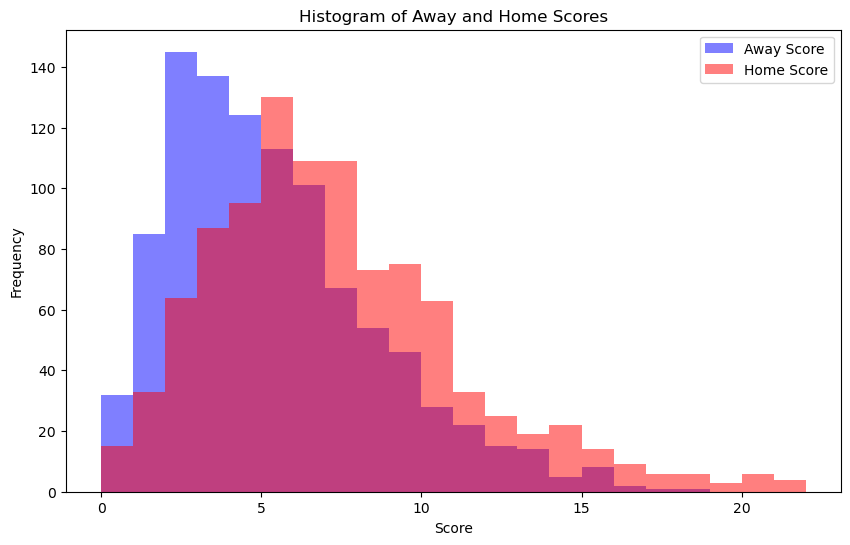

In [27]:
# Plot histograms
import matplotlib.pyplot as plt

score_df = extract_scores(game_list)

# Plot histograms with binsize of 1
plt.figure(figsize=(10, 6))

score_df['away_score'].plot.hist(bins=range(min(score_df['away_score']), max(score_df['away_score']) + 2, 1), alpha=0.5, color='blue', label='Away Score')
score_df['home_score'].plot.hist(bins=range(min(score_df['home_score']), max(score_df['home_score']) + 2, 1), alpha=0.5, color='red', label='Home Score')

plt.title('Histogram of Away and Home Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()